# Neural Style Transfer
This is a tutorial heavily taken from pytorch website

In [1]:
import os
import torch
from torch import nn, optim
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch.nn.functional as F
from copy import deepcopy

In [3]:
from torchvision import models

## Set the device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
dim = 512
transform = transforms.Compose([
    transforms.CenterCrop(dim),
    transforms.ToTensor()
])

In [6]:
def openImageFromPath(path):
    img = Image.open(path)
    img = transform(img).unsqueeze(0) ## Add extra dimensions
    return img.to(device, torch.float)

In [7]:
style_img_path = '../input/image-style-transfergoogle-images/Image_style_transfer/art/art_7.jpg'
content_img_path = '../input/image-style-transfergoogle-images/Image_style_transfer/train/train_4.jpg'

In [8]:
style_img =  openImageFromPath(style_img_path)
content_img = openImageFromPath(content_img_path)

In [9]:
unloader = transforms.ToPILImage()    

In [10]:
def display(tensor_img, title=None):
    img = tensor_img.cpu().clone()
    img = img.squeeze(0)
    img = unloader(img)
    plt.title(title)
    plt.imshow(img)

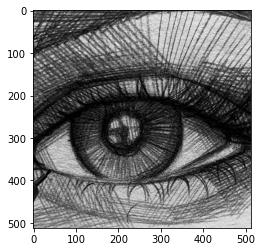

In [11]:
display(style_img)

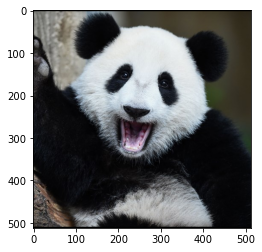

In [12]:
display(content_img)

# Content Loss

In [13]:
class ContentLoss(nn.Module):
    '''Implements content loss as a pytorch layer'''
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    
    def forward(self, inputTensor):
        self.loss = F.mse_loss(inputTensor, self.target)
        return inputTensor

# Gram Matrix Calculation for Style Loss

In [14]:
def normalisedGramMatrix(inputMatrix):
    d0, d1, d2, d3 = inputMatrix.size()
    features = inputMatrix.view(d0*d1, d2*d3)
    gmMatrix = features @ features.t()
    return gmMatrix /(d0*d1*d2*d3)

In [15]:
class StyleLoss(nn.Module):
    def __init__(self, targetfeature):
        super(StyleLoss, self).__init__()
        self.target = normalisedGramMatrix(targetfeature).detach()
        
    def forward(self, inputTensor):
        gmatrix = normalisedGramMatrix(inputTensor)
        self.loss = F.mse_loss(gmatrix, self.target)
        return inputTensor

In [16]:
cnnModel = models.vgg16(pretrained = True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [17]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [18]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = deepcopy(cnnModel)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

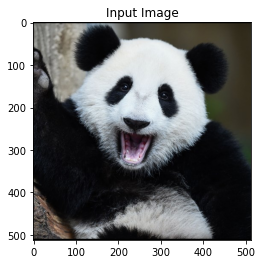

In [19]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
display(input_img, title='Input Image')

In [20]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

Building the style transfer model..


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Optimizing..
run [50]:
Style Loss : 45.343803 Content Loss: 18.006161

run [100]:
Style Loss : 12.583456 Content Loss: 18.012177

run [150]:
Style Loss : 5.258841 Content Loss: 16.920223

run [200]:
Style Loss : 2.899550 Content Loss: 15.789872

run [250]:
Style Loss : 2.000347 Content Loss: 14.842477

run [300]:
Style Loss : 1.585949 Content Loss: 14.163830



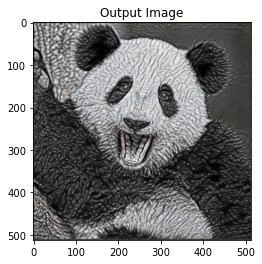

In [21]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

output = run_style_transfer(cnnModel, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
display(output, title='Output Image')
plt.show()